In [ ]:
!pip install Pillow
!pip install transformers==4.30.2 torch==2.0.1
!pip install scikit-learn

In [3]:
import os
import cv2
import numpy as np
import tensorflow as tf
from glob import glob
from skimage.io import imread
from skimage.transform import resize
from keras.preprocessing.image import ImageDataGenerator
from google.colab.patches import cv2_imshow
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import to_categorical
from keras.optimizers import Adam
from PIL import Image


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# paths for training and testing sets
training_set = '/content/drive/MyDrive/Brain Tumor data/Training'
test_set = '/content/drive/MyDrive/Brain Tumor data/Testing'

In [ ]:
# preprocess training set and save to drive
def preprocess_images(training_set, target_set, target_size=(512, 512)):
  if not os.path.exists(target_set):
        os.makedirs(target_set)

  preprocessed_data = []
  tumor_types = ["glioma", "meningioma", "notumor", "pituitary"]
  for tumor_type in tumor_types:
    type_path = os.path.join(training_set, tumor_type)
    target_type_path = os.path.join(target_set, tumor_type)

    if not os.path.exists(target_type_path):
            os.makedirs(target_type_path)

    if os.path.isdir(type_path):
      print(f"Processing directory: {type_path}")

      for image_name in os.listdir(type_path):
        image_path = os.path.join(type_path, image_name)
        target_image_path = os.path.join(target_type_path, image_name)
        image = cv2.imread(image_path)
        if image is not None:
          image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
          pil_image = Image.fromarray(image_rgb)
          resized_image = pil_image.resize((512, 512))
          resized_image.save(target_image_path)
          print(f"Saved image: {target_image_path}")
        else:
          print(f"Failed to read image: {image_path}")

training_set = '/content/drive/MyDrive/Brain Tumor data/Training'
resized_set = '/content/drive/MyDrive/Brain Tumor data/Resized Training'
preprocessed_data = preprocess_images(training_set, resized_set, (512, 512))


In [ ]:
# preprocess test set and save to drive
def preprocess_images(test_set, target_set, target_size=(512, 512)):
  if not os.path.exists(target_set):
        os.makedirs(target_set)

  preprocessed_data = []
  tumor_types = ["glioma", "meningioma", "notumor", "pituitary"]
  for tumor_type in tumor_types:
    type_path = os.path.join(test_set, tumor_type)
    target_type_path = os.path.join(target_set, tumor_type)

    if not os.path.exists(target_type_path):
            os.makedirs(target_type_path)

    if os.path.isdir(type_path):
      print(f"Processing directory: {type_path}")

      for image_name in os.listdir(type_path):
        image_path = os.path.join(type_path, image_name)
        target_image_path = os.path.join(target_type_path, image_name)
        image = cv2.imread(image_path)
        if image is not None:
          image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
          pil_image = Image.fromarray(image_rgb)
          resized_image = pil_image.resize((512, 512))
          resized_image.save(target_image_path)
          print(f"Saved image: {target_image_path}")
        else:
          print(f"Failed to read image: {image_path}")

test_set = '/content/drive/MyDrive/Brain Tumor data/Testing'
resized_set = '/content/drive/MyDrive/Brain Tumor data/Resized Testing'
preprocessed_data = preprocess_images(test_set, resized_set, (512, 512))

In [ ]:
# transfer learning ~ MobileNetVt
from keras.applications import MobileNetV2
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(512, 512, 3))

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

#Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

In [5]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.optimizers import Adam

# Load the trained model
model_path = '/content/drive/MyDrive/Brain Tumor data/NeuroModel.h5'
model = load_model(model_path)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.00004),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# load preprocessed images
resized_training = '/content/drive/MyDrive/Brain Tumor data/Resized Training'
resized_testing = '/content/drive/MyDrive/Brain Tumor data/Resized Testing'


# data augmentation parameters

train_datagen = ImageDataGenerator(
  rescale=1./255,
  rotation_range=110,
  width_shift_range=0.4,
  height_shift_range=0.4,
  shear_range=0.3,
  zoom_range=0.3,
  horizontal_flip=True,
  fill_mode='nearest',
  validation_split=0.2,
  channel_shift_range=0.3,
  vertical_flip=True,
  brightness_range=[0.5, 1.5]
)

# Validation data generator (no augmentation)
valid_datagen = ImageDataGenerator(rescale=1./255)

# generator for training data
train_generator = datagen.flow_from_directory(
    resized_training,
    target_size=(512, 512),
    batch_size=16,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

# generator for validation data
valid_generator = train_datagen.flow_from_directory(
    resized_training,
    target_size=(512, 512),
    batch_size=16,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)

# generator for testing data
test_generator = datagen.flow_from_directory(
    resized_testing,
    target_size=(512, 512),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)


from sklearn.utils.class_weight import compute_class_weight

# Get class weights
class_weights = compute_class_weight(
    class_weight = 'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes )

class_weights = dict(enumerate(class_weights))
class_weights[1] *= 2.8
class_weights[0] *= 1.5



print(class_weights)

print("Training Class:", train_generator.n)
print("Validation Class:", valid_generator.n)
print("Testing Class:", test_generator.n)


Found 4595 images belonging to 4 classes.
Found 1147 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
{0: 1.5940101757631824, 1: 3.000466417910448, 2: 0.9002742946708464, 3: 0.9852058319039451}
Training Class: 4595
Validation Class: 1147
Testing Class: 1311


In [ ]:
## MODEL TRAINING

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Load the trained model
model_path = '/content/drive/MyDrive/Brain Tumor data/NeuroModel.h5'
model = load_model(model_path)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.00004),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = valid_generator.n // valid_generator.batch_size
test_steps = test_generator.n // test_generator.batch_size

print("Starting training...")
history = model.fit(
    train_generator,
    steps_per_epoch=10,
    validation_data=valid_generator,
    validation_steps=10,
    class_weight=class_weights,
    #callbacks=[checkpoint_callback]
)

print("Training complete.")


In [ ]:
model.save('/content/drive/MyDrive/Brain Tumor data/NeuroModel.h5')

In [5]:
# MODEL TESTING

from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


model_path = '/content/drive/MyDrive/Brain Tumor data/NeuroModel.h5'
model = load_model(model_path)

datagen = ImageDataGenerator(rescale=1./255)
resized_testing = '/content/drive/MyDrive/Brain Tumor data/Resized Testing'


test_generator = datagen.flow_from_directory(
    resized_testing,
    target_size=(512, 512),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

# Evaluate the loaded model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

# make predictions
predictions = model.predict(test_generator)
predicted_classes= np.argmax(predictions, axis=1)
y_true = test_generator.classes

#get true classes:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Print the classification report
print("Classification Report:")
report = classification_report(y_true, predicted_classes, target_names=class_labels)
print(report)


Found 1311 images belonging to 4 classes.
82/82 [==============================] - 276s 3s/step - loss: 0.4092 - accuracy: 0.8604
Test accuracy: 0.8604118824005127
Test loss: 0.40923452377319336
82/82 [==============================] - 49s 582ms/step
Classification Report:
              precision    recall  f1-score   support

      glioma       0.95      0.76      0.84       300
  meningioma       0.72      0.75      0.73       306
     notumor       0.92      0.96      0.94       405
   pituitary       0.86      0.94      0.90       300

    accuracy                           0.86      1311
   macro avg       0.86      0.85      0.85      1311
weighted avg       0.86      0.86      0.86      1311



Tumor Type: Glioma


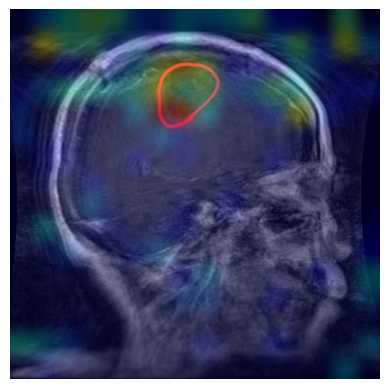

A Glioma brain tumor has been identified in the patient's brain scan. Gliomas are tumors that originate from the glial cells, which support and protect neurons in the brain. 
They can be benign or malignant and are categorized into different grades based on their aggressiveness:

Grade I: Typically slow-growing and less aggressive; treatment often involves surgical removal.
Grade II: More likely to spread; may require additional treatments such as radiation therapy.
Grade III: Malignant tumors that grow rapidly and may infiltrate surrounding brain tissue; treatment usually involves surgery, radiation, and chemotherapy.
Grade IV: Highly aggressive with a poor prognosis; requires aggressive treatment strategies, including surgery, radiation, chemotherapy, and possibly clinical trials for experimental therapies.

Symptoms:
Patients with gliomas may experience persistent headaches, seizures, or neurological deficits, including changes in vision, speech, or motor functions. 
The severity an

In [9]:
## GRAD-CAM INTEGRATION

import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.models import load_model, Model
from keras.layers import Conv2D
import tensorflow as tf
import matplotlib
import warnings
import transformers
from transformers import GPT2Config, GPT2Tokenizer, GPT2LMHeadModel

#load model
model_path = '/content/drive/MyDrive/Brain Tumor data/NeuroModel.h5'

base_model = load_model(model_path)


conv_layers = [layer for layer in base_model.layers if isinstance(layer, Conv2D)]

chosen_layer = conv_layers[-5].name

def get_img_array(img_path, size):
  img = image.load_img(img_path, target_size=size)
  array = image.img_to_array(img)
  array = np.expand_dims(array, axis=0)
  array = array / 255.0
  return array


def make_gradcam_map(img_array, layer_name, model, pred_index=None):
  grad_model = Model(inputs=[model.inputs], outputs=[model.get_layer(chosen_layer).output, model.output])
  with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_array)
    if pred_index is None:
      pred_index = tf.argmax(predictions[0]) # finds class index w/ highest predicted score
    class_channel = predictions[:, pred_index]

  grads = tape.gradient(class_channel, conv_outputs)
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

  conv_outputs = conv_outputs[0]
  heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
  heatmap = tf.squeeze(heatmap)
  heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
  return heatmap.numpy(), np.argmax(predictions[0].numpy())

def display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
  img = image.load_img(img_path)
  img = image.img_to_array(img)
  heatmap = np.uint8(255 * heatmap)

  jet = matplotlib.colormaps['jet']
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  jet_heatmap = image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = image.img_to_array(jet_heatmap)

  superimposed_img = jet_heatmap * alpha + img
  superimposed_img = image.array_to_img(superimposed_img)
  superimposed_img.save(cam_path)

  plt.imshow(superimposed_img)
  plt.axis('off')
  plt.show()

#Creating Heatmap
img_path = '/content/drive/MyDrive/Brain Tumor data/Annotated/glioma/Tr-gl_1094.jpeg'
img_array = get_img_array(img_path, (512, 512))

heatmap, pred_index = make_gradcam_map(img_array, chosen_layer, base_model)
class_indices = train_generator.class_indices
tumor_types = list(class_indices.keys())
print("Tumor Type:", tumor_types[pred_index].capitalize())
display_gradcam(img_path, heatmap)


#GPT Integration
import transformers
from transformers import GPT2Config, GPT2Tokenizer, GPT2LMHeadModel

configuration = GPT2Config()
#model = GPT2Model(configuration)
configuration = model.config
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")


if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

# get predicted tumor
tumor_identified = tumor_types[pred_index].capitalize()


base_prompt = {
    "Meningioma": (
        "A Meningioma brain tumor has been identified in the patient's brain scan. Meningiomas are typically benign and slow-growing tumors that originate from the meninges, \n"
        "the protective layers surrounding the brain and spinal cord. "
        "Although generally benign, they can cause symptoms by pressing on the brain or spinal cord. \n"
        "Symptoms:\nMeningiomas may lead to headaches, seizures, vision problems, or other neurological issues due to their pressure on surrounding structures.\n\n"
        "Treatment Options:\nSurgery: Often the primary treatment, aiming to remove the tumor while preserving neurological function.\n"
        "Radiation Therapy: Used when surgery is not feasible or to target residual tumor cells.\n\n"
        "Prognosis:\nThe prognosis for meningioma patients is generally favorable, especially if the tumor is completely removed. Regular follow-up is essential to monitor for recurrence.\n\n"
        "Action Steps:\nFurther Evaluation: Additional imaging or biopsy may be required to assess the tumor's characteristics and plan treatment.\n"
        "Treatment Planning: Work with a multidisciplinary team to develop an individualized treatment strategy based on the tumor's size, location, and the patient's overall health.\n"
        "Patient Support: Provide resources and support for the patient, including information on treatment options and potential side effects."
    ),

    "Glioma": (
        "A Glioma brain tumor has been identified in the patient's brain scan. Gliomas are tumors that originate from the glial cells, which support and protect neurons in the brain. \n"
        "They can be benign or malignant and are categorized into different grades based on their aggressiveness:\n\n"
        "Grade I: Typically slow-growing and less aggressive; treatment often involves surgical removal.\n"
        "Grade II: More likely to spread; may require additional treatments such as radiation therapy.\n"
        "Grade III: Malignant tumors that grow rapidly and may infiltrate surrounding brain tissue; treatment usually involves surgery, radiation, and chemotherapy.\n"
        "Grade IV: Highly aggressive with a poor prognosis; requires aggressive treatment strategies, including surgery, radiation, chemotherapy, and possibly clinical trials for experimental therapies.\n\n"
        "Symptoms:\nPatients with gliomas may experience persistent headaches, seizures, or neurological deficits, including changes in vision, speech, or motor functions. \n"
        "The severity and type of symptoms often correlate with the tumor's location and grade.\n\n"
        "Treatment Options:\nSurgery: Aims to remove as much of the tumor as possible while preserving brain function.\n"
        "Radiation Therapy: Used to target and destroy remaining tumor cells after surgery or when surgery is not feasible.\n"
        "Chemotherapy: Utilizes drugs to kill or inhibit tumor cells, often used in conjunction with surgery and radiation.\n\n"
        "Prognosis:\nThe prognosis for glioma patients depends on the tumor's grade, location, and the patient’s overall health. Early detection and a comprehensive treatment plan can improve outcomes.\n\n"
        "Action Steps:\nFurther Evaluation: Consider additional imaging or biopsy if not already performed to determine the exact grade and extent of the tumor.\n"
        "Treatment Planning: Collaborate with a multidisciplinary team including neurosurgeons, oncologists, and radiologists to create a personalized treatment plan.\n"
        "Patient Support: Provide support resources for the patient, including information on treatment options and potential side effects."
    ),

    "Pituitary": (
        "A Pituitary tumor has been identified in the patient's brain scan. Pituitary tumors are abnormal growths that develop in the pituitary gland, which is located at the base of the brain. "
        "These tumors can disrupt hormone production and lead to a range of symptoms, including vision problems, headaches, and hormonal imbalances. Pituitary tumors can be classified based on their hormonal activity and location within the gland:\n\n"
        "Functional Pituitary Tumors: Secrete excess hormones, causing conditions such as Cushing's disease, acromegaly, or prolactinoma.\n"
        "Non-Functional Pituitary Tumors: Do not secrete hormones but can cause symptoms by pressing on nearby structures, including the optic nerves.\n\n"
        "Symptoms:\nCommon symptoms include visual disturbances, headaches, and hormonal imbalances such as abnormal growth, metabolism, or reproductive functions.\n\n"
        "Treatment Options:\nSurgery: Aims to remove the tumor, often performed through a transsphenoidal approach.\n"
        "Medication: Used to control hormone levels and manage symptoms, particularly for functional tumors.\n"
        "Radiation Therapy: May be considered if surgery is not fully effective or if the tumor is not operable.\n\n"
        "Prognosis:\nPrognosis varies depending on the tumor type, size, and treatment response. Many patients have favorable outcomes with appropriate management, but ongoing follow-up is important.\n\n"
        "Action Steps:\nFurther Evaluation: Additional imaging or testing may be needed to assess the tumor's characteristics and impact on hormone levels.\n"
        "Treatment Planning: Collaborate with endocrinologists and neurosurgeons to develop a personalized treatment plan.\n"
        "Patient Support: Offer resources and support related to managing symptoms, understanding treatment options, and addressing any side effects."
    ),

    "No Tumor": (
        "No brain tumor has been identified in the patient's scan. This result suggests that the observed abnormalities are not due to a tumor but may be related to other factors such as inflammation, infection, or benign conditions. "
        "Further medical evaluation is recommended to determine the exact cause of the abnormalities. This may include additional imaging, tests, or consultations with specialists to provide a comprehensive diagnosis and appropriate care plan.\n\n"
        "Action Steps:\nFurther Evaluation: Consider additional diagnostic tests or imaging studies to clarify the nature of the abnormalities observed.\n"
        "Consultation: Follow up with healthcare providers to explore any symptoms or concerns and determine the next steps for diagnosis or treatment.\n"
        "Patient Support: Provide information and support for the patient regarding potential causes of their symptoms and options for further evaluation."
    )
}



input_text = base_prompt.get(tumor_identified, "No information available for this type of tumor.")

input_ids = tokenizer(input_text, return_tensors="pt")['input_ids']
inputs = tokenizer(input_text, return_tensors="pt")

# Generate the text with attention mask
generated_text = model.generate(
    inputs['input_ids'],
    attention_mask=inputs['attention_mask'],
    max_length = len(input_ids[0])+1,
    pad_token_id=tokenizer.eos_token_id
)
output_text = tokenizer.decode(generated_text[0], skip_special_tokens=True)
print(output_text)
warnings.filterwarnings("ignore", category=FutureWarning, module='huggingface_hub')
